\author{Lewis Li, Daniel Brito}
# Introduction 

In this part of the project, we are assuming that steam is being injected into a well at a constant pressure, rate and quality. We will evaluate the project success as a function of time, by estimating the changes in thermal efficiency, area of steam zone, and cumulative oil production. We will apply this based on the numbers from the Kern River project, which assumes a project life of 20 years. The reservoir parameters are assumed to be well understood, and is given below:

|Symbol    | Units   | Value   | Description  |  
|---|---|---|-------------------------|
|$T_r$   | F  | 90  | Reservoir temperature |  
|$phi$   | %  | 0.32  |  Reservoir porosity |   
|$h$   | ft  | 55  | Net pay thickness |   
|$S_{or}$   | %  | 0.15  | Residual oil saturation   |   
|$\Delta S_{o}$ | %  | 0.4  |Oil saturation variation   |    
|$M_s$   | BTU/cu.ft-F  | 42  | Overburden volumetric heat capacity |   
|$M_t$   | BTU/cu.ft-F  | 35  |  Total formation volumetric heat capacity |   
|$K_s$   | BTU/cu.ft-F-hr  | 1.2  | Overburden thermal conductivity  |   

In [1]:
Tr = 90;                % Reservoir temperature (F)
phi = 0.32;             % Porosity 
h = 55;                 % Net pay thickness(ft)
Sor = 0.15;             % Residual oil saturation           
deltaSo = 0.4;          % Oil saturation variation
Ms = 42;                % BTU/cu.ft-F
Mt = 35;                % BTU/cu.ft-F
Ks = 1.2;               % BTU/cu.ft-F-hr


The steam injection conditions and steam properties are given as:

|Symbol    | Units   | Value   | Description  |  
|---|---|-----------:|:----------------------------------|
|$P_{bh}$   | psig  | 100  | Bottom hole injection pressure |  
|rate   |  bbl/day  | 360  |   bbl/day CWE (i.e., the rate on a condensed water basis) |   
|$X_{bh}$   | ft  | 0.5  |  Steam quality |   
|$A_{well}$   | acres  | 2.5  | Drainage area   |   
|$T_s$   | F  | 338  | Steam temperature    |   
|$\Delta_H^v$   | n/a  | 880  | delta-H for vapour   |   
|$HwTs$   | BTU/lb  | 310  | enthalpy of water @ steam temperature   |   
|$HwTr$   | BTU/lb  | 58  | enthalpy of water @ reservoir temperature   |   
|$C_w$   | BTU/lb-F  | $\frac{HwTs - HwTr}{T_s - T_r}$  | heat capacity of water over the temperature range   |   


In [2]:
% Bottom hole injection pressure (psig)
Pbh = 100;                      
% bbl/day CWE (i.e., the rate on a condensed water basis)
rate = 360;                     
% Steam quality
Xbh = 0.5;                      
% Drainage area 
acresPerWell = 2.5;             
% Steam temperature (F)
Ts = 338;                       
% delta_H for vapour
deltaHv = 880;                  
% BTU/lb @ steam temp
HwTs = 310;                     
% BTU/lb @ res temp 
HwTr = 58;                      
% (BTU/lb-F)
Cw = (HwTs - HwTr) / (Ts - Tr); 

The mass injection rate can be just evaluated as follows:

In [3]:
%Mass injection rate
DaysInYear = 365;
VolInBarrel = 5.615; %ft3/B
Density = 62.4; %lb/ft^3
% Rate of injection (lb/year)
mi = rate * VolInBarrel * Density * DaysInYear;  

Our next step is to convert time into a dimensionless unit which is given as:
$$t_d = 4t \left( \frac{M_s}{M_t} \right)^2 \left( \frac{\alpha_s}{h^2} \right)$$

In [4]:
%% Thermal diffusivity
alphaSs = 1.2*24/42;            % Thermal diffusivity (ft^2/day)


%% Descritize time
t = [0.02098296, 0.10491482, 0.20982964, 1.34290969, ...
2.09829639, 4.19659278,6.29488917, 8.39318557, ...
10.491482, 20.9829639, 41.9659278, 62.9488917];
t = t * DaysInYear;

%% Calculate dimensionless time
td = 4 * t * ( Ms / Mt )^2 * ( alphaSs / h^2 );
ti = t / DaysInYear;


The heat injection rate is evaluated as:
$$Q_i = \left( \dot{m}_i C_W \Delta T + X \dot{m}_i \Delta H_w \right) t$$

In [5]:
Qi = ( mi * Cw * (Ts - Tr)  + Xbh * mi * deltaHv ) * ti;

We need to evaluate the reservoir heat efficiency. We will use two different approaches: 1) Marx-Langenheim and 2) Myhill-Stegemeier

# Marx-Langenheim
In Marx-Langenheim, the reservoir heat efficiency is evaluated as:

$$E_h = \frac{2\sqrt{\frac{t_D}{\pi}} - 1 + e^{t_d}erfc \sqrt{t_D}}{t_D}$$


In [6]:
EhMarx = (2*sqrt(td/pi) - 1 + exp(td).* erfc( sqrt(td)))./td;

The steam volume is then just:
$$V_s = \frac{Q_iE_h}{M_T\Delta T}$$

In [7]:
VsMarx = Qi.*EhMarx / (Mt * (Ts - Tr));

The cumulative oil production is:
$$N_p = V_s \phi \Delta S_o$$

In [8]:
NpMarx = VsMarx .* phi * deltaSo / VolInBarrel;

The OSR (Oil Steam Ratio) is determined by:

$$ OSR = \frac{N_p}{V_{s,eq}}$$

In [9]:
OSRMarx= NpMarx./(mi*(t/DaysInYear)/(Density*VolInBarrel));

The area covered by the steam is:
$$Acres = \frac{V_s}{h}$$

In [10]:
AcresMarx = VsMarx ./ h;

# Myhill-Stegemeier
The second approach we will use to evaluate the reservoir heat efficiency is the Myhill-Stegemeier technique. The first step is to evaluate the critical time using the expression:
$$e^{t_{cD}} erfc\sqrt{t_{cD}} = \frac{1}{1+h_D}$$

where $h_D$ is the ratio of latent heat to sensible heat:
$$h_D = \frac{X\Delta H_v}{C_w\Delta T}$$

In [11]:
hd = Xbh * deltaHv / (Cw *(Ts - Tr) );  % latent heat / sensible heat
tcd = fsolve(@(tcD) exp(tcD).*erfc(sqrt(tcD)) -1/(1+hd),[1], ...
optimset('Algorithm','levenberg-marquardt','Display','iter'));  
tcd = tcd(end);

First-Order                    Norm of 
 Iteration  Func-count    Residual       optimality      Lambda           step
     0           2      0.00402232         0.00866         0.01
     1           4      0.00076832         0.00284        0.001       0.302283
     2           6     2.28396e-05        0.000403       0.0001       0.246897
     3           8     2.58217e-08         1.3e-05        1e-05      0.0558744
     4          10     1.27913e-13        2.89e-08        1e-06     0.00198069
     5          12     3.04758e-21        4.47e-12        1e-07    4.42068e-06
     6          14     1.11242e-30        8.53e-17        1e-08    6.82449e-10

Equation solved.

fsolve completed because the vector of function values is near zero
as measured by the default value of the function tolerance, and
the problem appears regular as measured by the gradient.


We next evaluate the variable rate of G:
$$G(t_D) = \left( 2 \sqrt{\frac{t_d}{\pi}} - 1 + e^{t_D} erfc \sqrt{t_D} \right)$$

In [12]:
G = 2 * sqrt ( td / pi ) - 1 + exp( td ).* erfc( sqrt(td));

The reservoir heat efficiency is then evaluated as:
$$ E_h(t_D) = \frac{1}{t_D} \left\lbrace G(t_D) + \frac{U(t_D-t_{cD})}{\sqrt{\pi} (1 +h_D)} \left[ 2\sqrt{t_D} - \frac{2 \sqrt{t_D - t_{cD}} }{(1+h_D)} - \int_{0}^{t_cD}  \frac{e^x erfc\sqrt{x}} {\sqrt{t_D - x}} dx - \sqrt{\pi} G(t_D) \right] \right\rbrace$$

In [13]:
N = length(td);
EhMyHill = zeros (1,N);

for i = 1:N     
    errorFun = @(u) exp(u).*erfc(sqrt(u))./sqrt(td(i) - u); 
    EhMyHill(i) = 1/td(i) * ( G(i) + ( (td(i) > tcd)/...
    ( sqrt(pi)*(1+hd)))*(2*sqrt(td(i))-...
    ( 2*sqrt(td(i) - tcd) )/( 1 + hd )- ...
    integral(errorFun, 0, tcd) - sqrt(pi) * G(i) ) );    
end


The steam volume, cumulative production, OSR and area can be calculated using the same expressions as above.

In [14]:
% Steam volume (ft^3)
VsMyHill = Qi.*EhMyHill / (Mt * (Ts - Tr));  
% Np (bbl)
NpMyHill = VsMyHill .* phi * deltaSo / VolInBarrel;   
% oil/steam ratio
OSRMyHill= NpMyHill./(mi*(t/DaysInYear)/(Density*VolInBarrel)); 
% Area (acres)
AreaMyHill = VsMyHill ./ h;                     

# Results
The results for both approaches are plotted below:

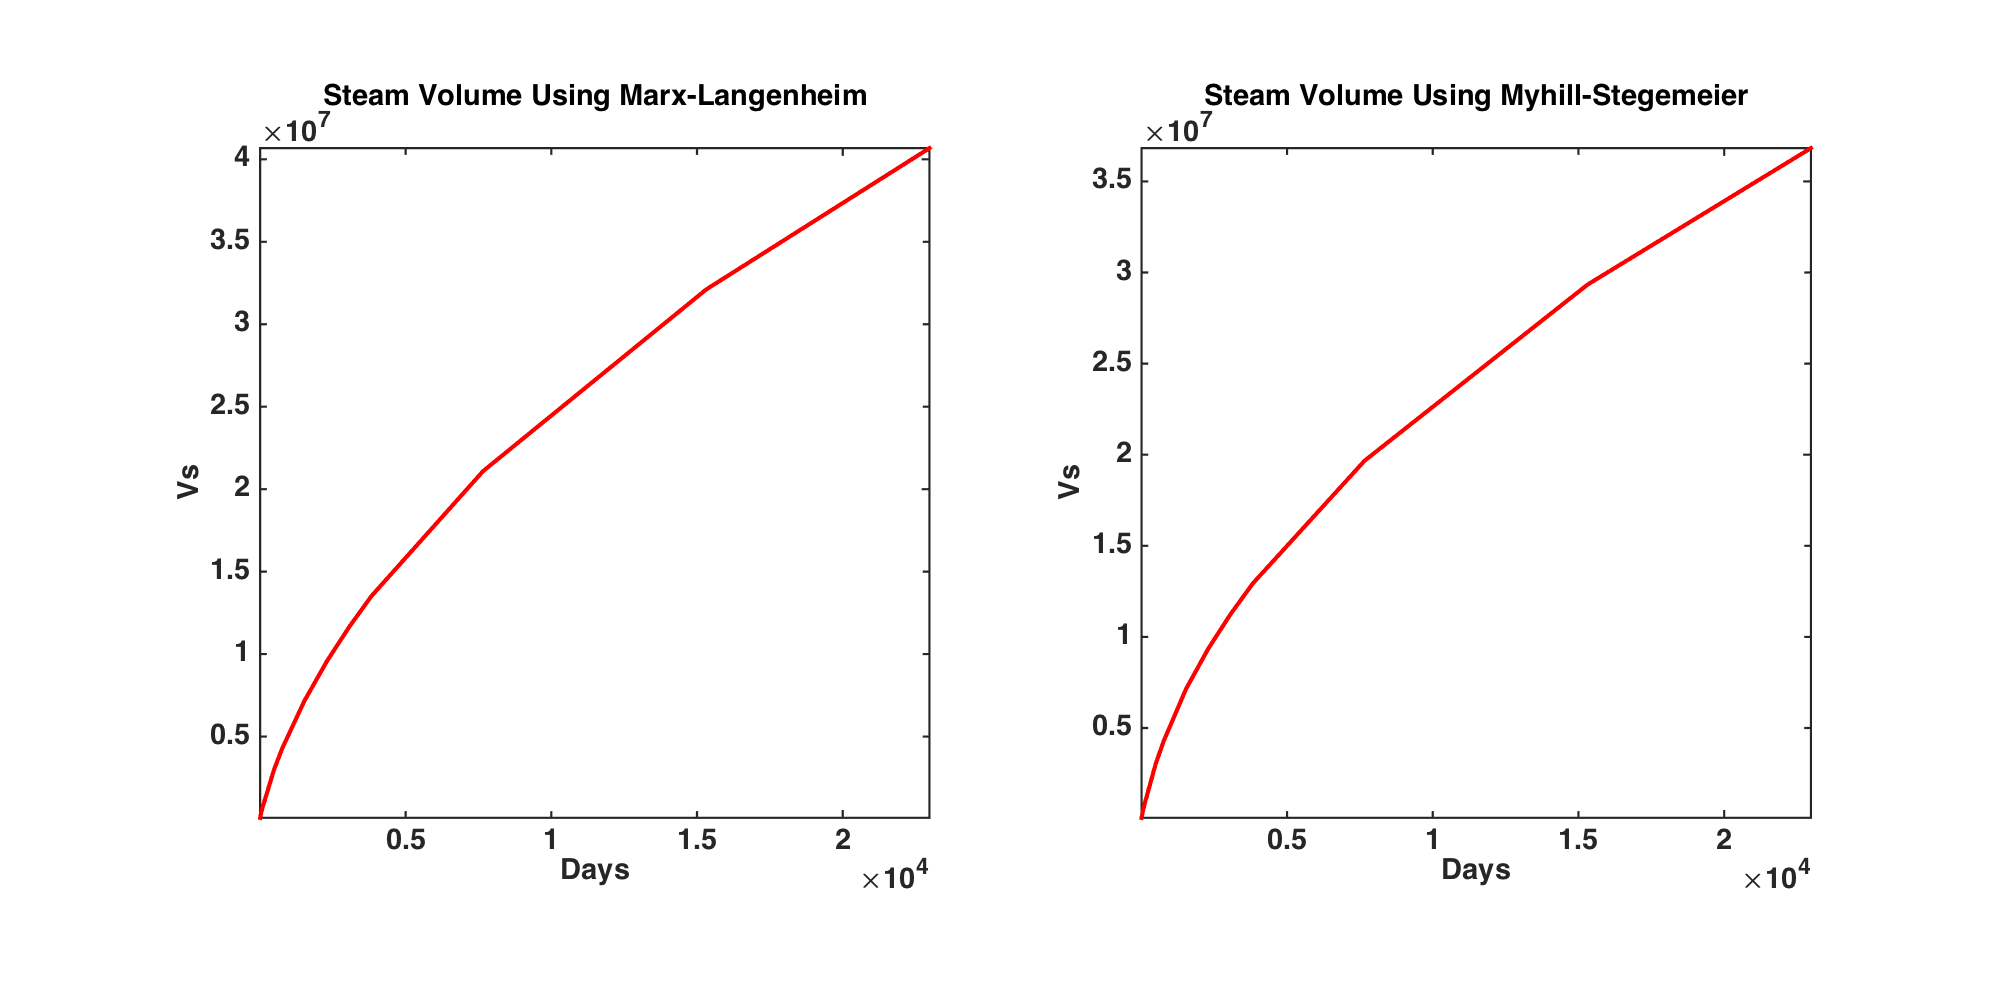

In [15]:
%plot inline -s 2000,1000
subplot(1,2,1);
plot(t,VsMarx,'r-','LineWidth',2);
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('Vs','FontSize',14,'FontWeight','bold')        
title({'Steam Volume Using Marx-Langenheim';''},'FontSize',14);
set(gca,'FontSize',14,'FontWeight','bold');
axis tight; axis square;

subplot(1,2,2);
plot(t,VsMyHill,'r-','LineWidth',2);
hold on;
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('Vs','FontSize',14,'FontWeight','bold')        
set(gca,'FontSize',14,'FontWeight','bold');
title({'Steam Volume Using Myhill-Stegemeier';''},'FontSize',14);
axis tight; axis square;

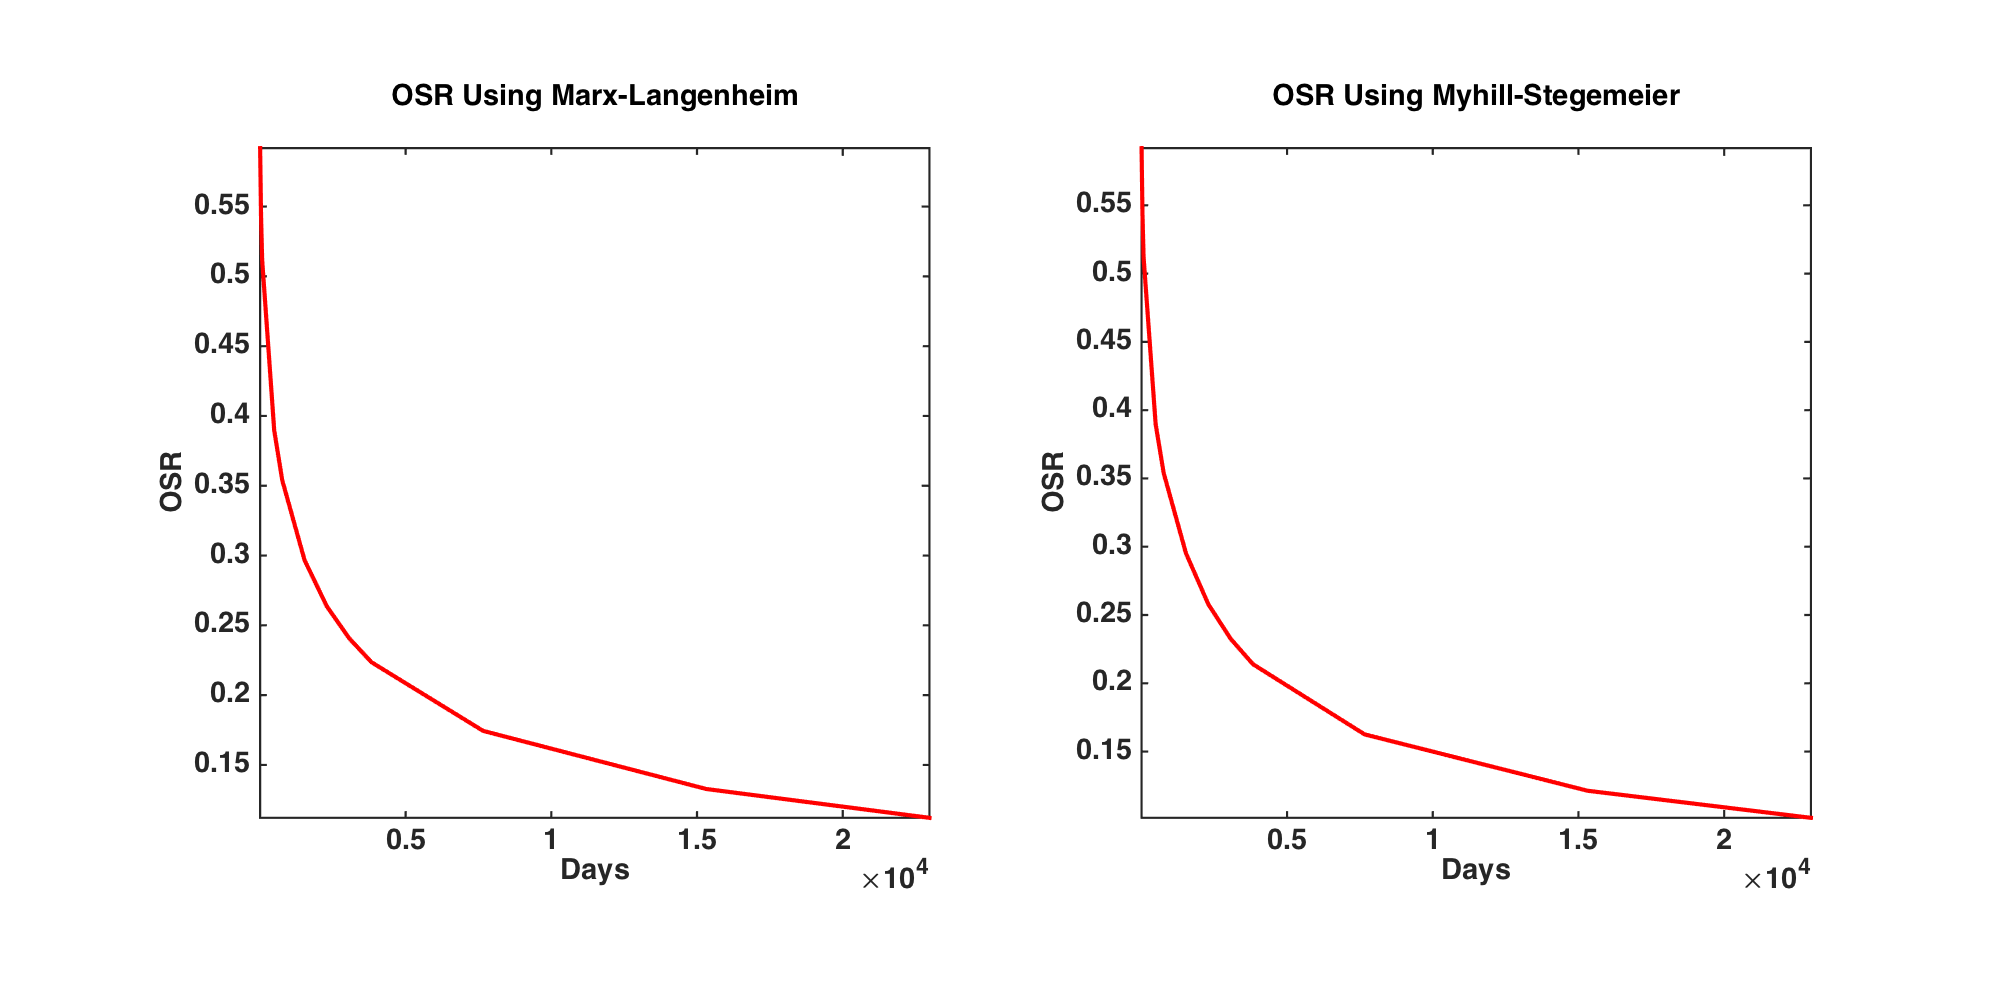

In [16]:
%plot inline -s 2000,1000
subplot(1,2,1);
plot(t,OSRMarx,'r-','LineWidth',2);
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('OSR','FontSize',14,'FontWeight','bold')        
title({'OSR Using Marx-Langenheim';''},'FontSize',14);
set(gca,'FontSize',14,'FontWeight','bold');
axis tight; axis square;

subplot(1,2,2);
plot(t,OSRMyHill,'r-','LineWidth',2);
hold on;
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('OSR','FontSize',14,'FontWeight','bold')        
set(gca,'FontSize',14,'FontWeight','bold');
title({'OSR Using Myhill-Stegemeier';''},'FontSize',14);
axis tight; axis square;

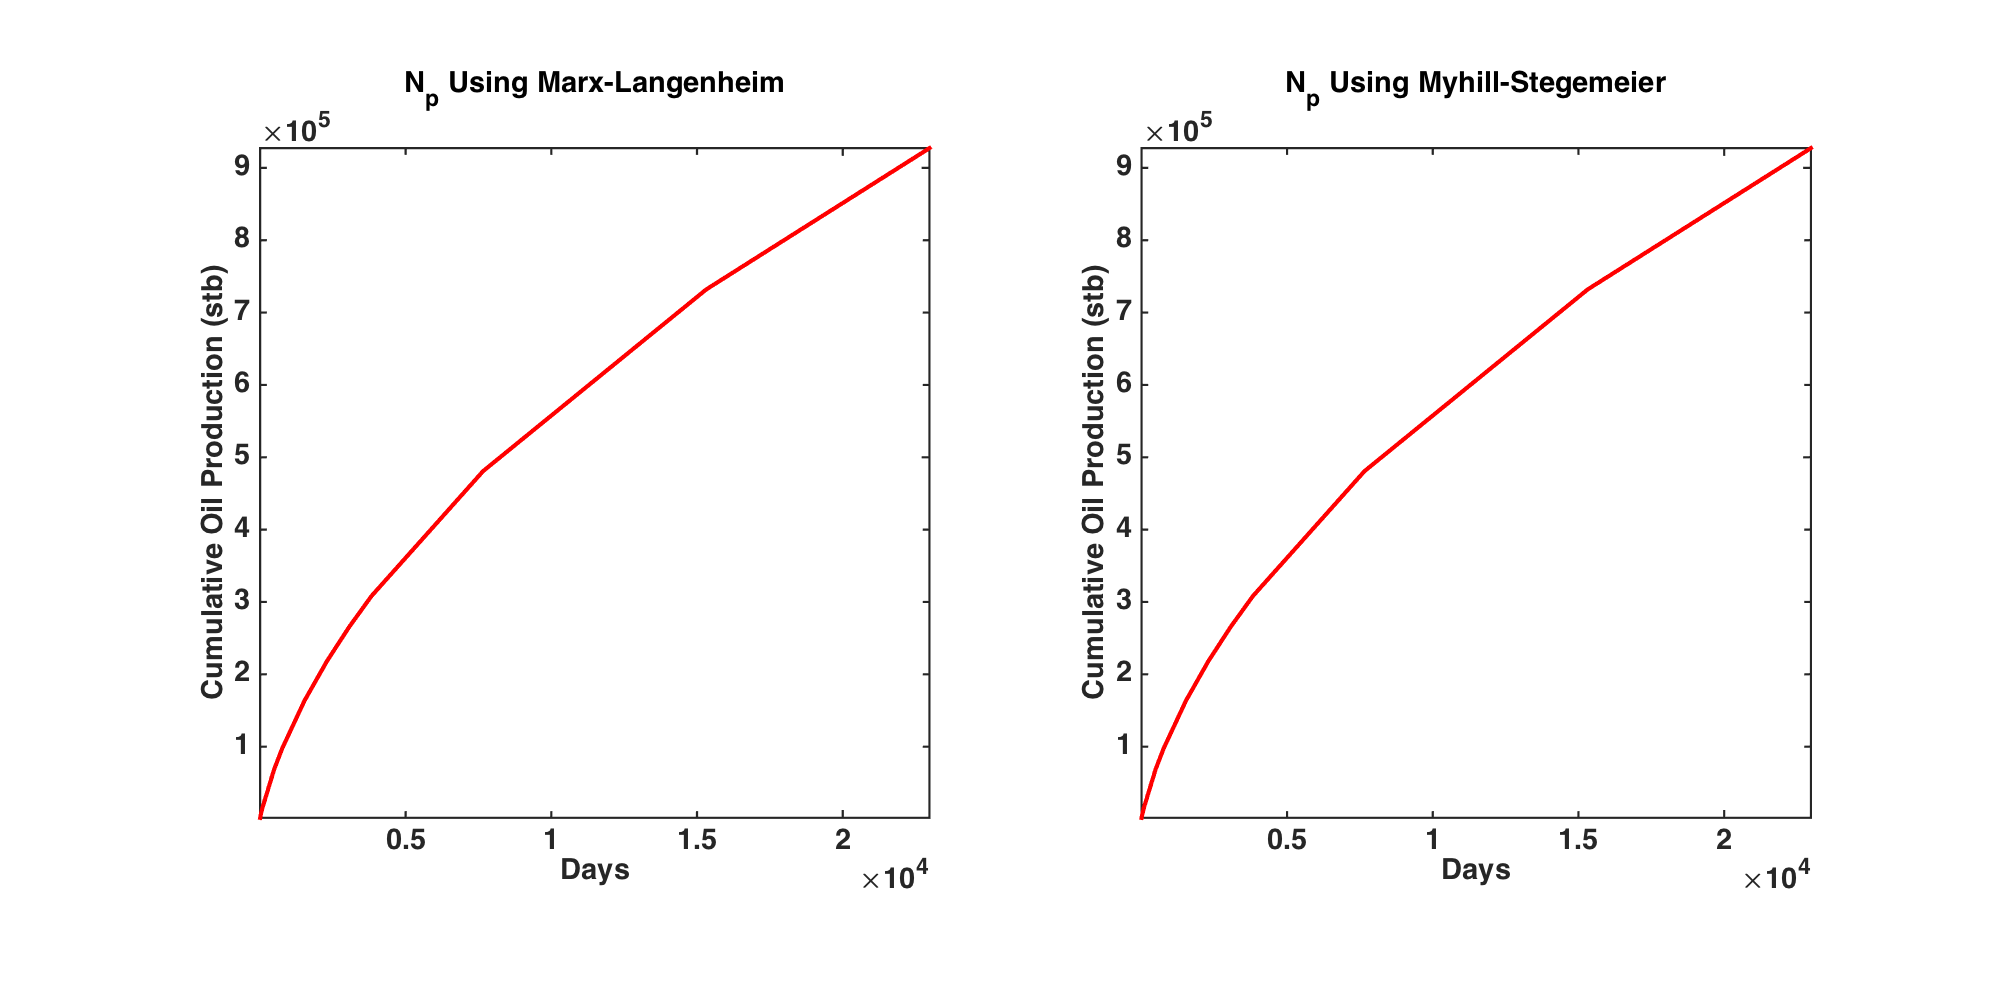

In [17]:
%plot inline -s 2000,1000
subplot(1,2,1);
plot(t,NpMarx,'r-','LineWidth',2);
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('Cumulative Oil Production (stb)',...
'FontSize',14,'FontWeight','bold')        
title({'N_p Using Marx-Langenheim';''},'FontSize',14);
set(gca,'FontSize',14,'FontWeight','bold');
axis tight; axis square;

subplot(1,2,2);
plot(t,NpMarx,'r-','LineWidth',2);
hold on;
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('Cumulative Oil Production (stb)',...
'FontSize',14,'FontWeight','bold')        
set(gca,'FontSize',14,'FontWeight','bold');
title({'N_p Using Myhill-Stegemeier';''},'FontSize',14);
axis tight; axis square;

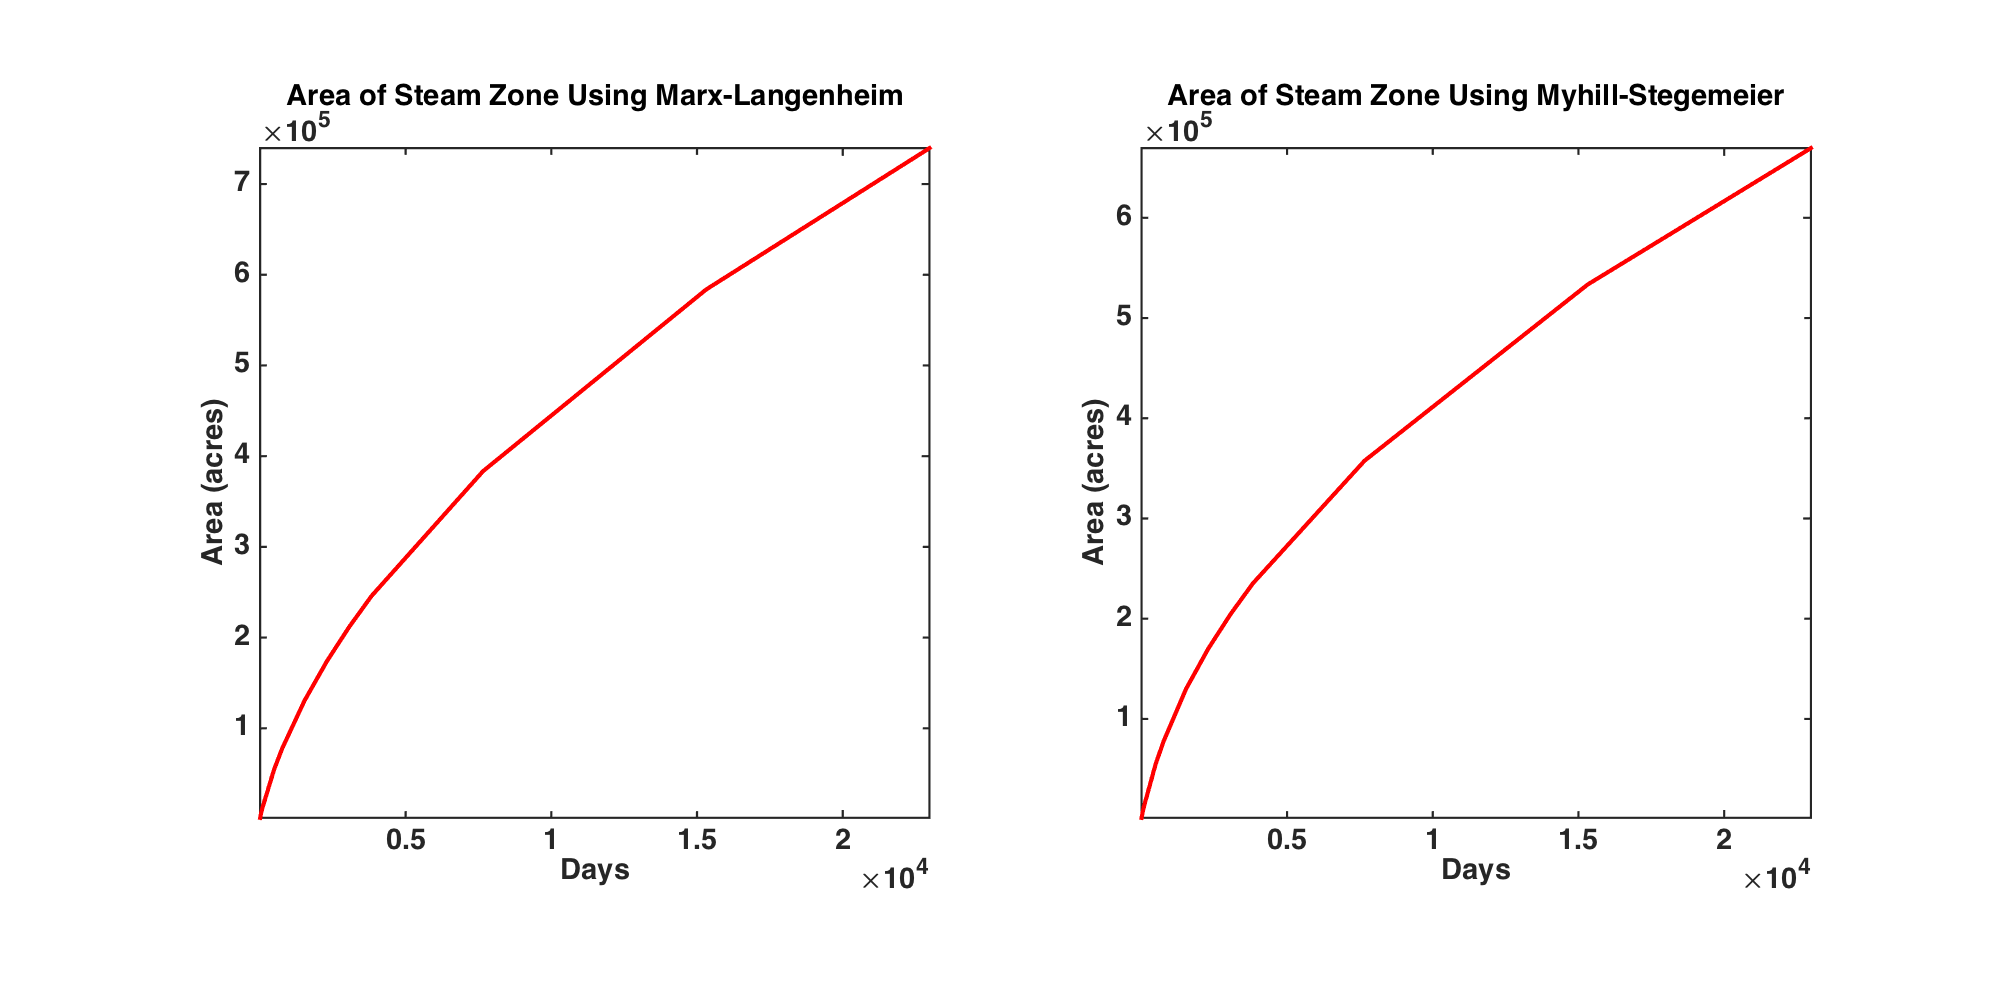

In [18]:
%plot inline -s 2000,1000
subplot(1,2,1);
plot(t,AcresMarx,'r-','LineWidth',2);
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('Area (acres)','FontSize',14,'FontWeight','bold')        
title({'Area of Steam Zone Using Marx-Langenheim';''},...
'FontSize',14);
set(gca,'FontSize',14,'FontWeight','bold');
axis tight; axis square;

subplot(1,2,2);
plot(t,AreaMyHill,'r-','LineWidth',2);
hold on;
xlabel('Days','FontSize',14,'FontWeight','bold')
ylabel('Area (acres)','FontSize',14,'FontWeight','bold')        
set(gca,'FontSize',14,'FontWeight','bold');
title({'Area of Steam Zone Using Myhill-Stegemeier';''},...
'FontSize',14);
axis tight; axis square;

In [19]:
Results = [td' t' EhMarx' Qi' VsMarx' AcresMarx' NpMarx' OSRMarx'];
format shortEng
format compact

display('Results for Marx-Langenheim are as follows:');
display('              tD               t             Ehs              Qi');
display(Results(:,1:4));
display('              Vs           Acres              Np             OSR');
display(Results(:,5:end));

Results for Marx-Langenheim are as follows:
              tD               t             Ehs              Qi
ans =
    10.0000e-003     7.6588e+000   929.4897e-003   668.5018e+006
    50.0000e-003    38.2939e+000   853.8003e-003     3.3425e+009
   100.0000e-003    76.5878e+000   804.0326e-003     6.6850e+009
   640.0000e-003   490.1620e+000   612.1936e-003    42.7841e+009
     1.0000e+000   765.8782e+000   555.9627e-003    66.8502e+009
     2.0000e+000     1.5318e+003   465.9866e-003   133.7004e+009
     3.0000e+000     2.2976e+003   413.9171e-003   200.5506e+009
     4.0000e+000     3.0635e+003   378.0385e-003   267.4008e+009
     5.0000e+000     3.8294e+003   351.0918e-003   334.2509e+009
    10.0000e+000     7.6588e+003   273.8826e-003   668.5019e+009
    20.0000e+000    15.3176e+003   208.4739e-003     1.3370e+012
    30.0000e+000    22.9763e+003   176.0585e-003     2.0055e+012
              Vs           Acres              Np             OSR
ans =
    71.5859e+003     1.3016e+003  

In [20]:
Results = [td' t' EhMyHill' Qi' VsMyHill' AreaMyHill' NpMyHill' OSRMyHill'];
format shortEng
format compact

display('Results for Myhill-Stegemeier are as follows:');
display('              tD               t             Ehs              Qi');
display(Results(:,1:4));
display('              Vs           Acres              Np             OSR');
display(Results(:,5:end));

Results for Myhill-Stegemeier are as follows:
              tD               t             Ehs              Qi
ans =
    10.0000e-003     7.6588e+000   929.4897e-003   668.5018e+006
    50.0000e-003    38.2939e+000   853.8003e-003     3.3425e+009
   100.0000e-003    76.5878e+000   804.0326e-003     6.6850e+009
   640.0000e-003   490.1620e+000   612.1936e-003    42.7841e+009
     1.0000e+000   765.8782e+000   555.9627e-003    66.8502e+009
     2.0000e+000     1.5318e+003   463.5257e-003   133.7004e+009
     3.0000e+000     2.2976e+003   405.0423e-003   200.5506e+009
     4.0000e+000     3.0635e+003   365.3067e-003   267.4008e+009
     5.0000e+000     3.8294e+003   336.0558e-003   334.2509e+009
    10.0000e+000     7.6588e+003   255.3770e-003   668.5019e+009
    20.0000e+000    15.3176e+003   190.4923e-003     1.3370e+012
    30.0000e+000    22.9763e+003   159.3830e-003     2.0055e+012
              Vs           Acres              Np             OSR
ans =
    71.5859e+003     1.3016e+003